In [1]:
import numpy as np
import cmocean
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from tabulate import tabulate
from scipy.stats import zscore, norm
import seaborn as sns
import pandas as pd

wav_data = np.load('sentinel2_rochester.npy')

The above cell includes all of the imports needed for the project as well as the import for the sentinel 2 rochester dataset.

plot_band takes in 1 specified spectral band and creates a plot. First values are noramlized to ensure comparability across different bands, this reduces the impact of scaling on the visualization of the data across different plots that are to be compared. Then NAN values are set equal to 0, this value creates a distinguished border around the real relfectance values and therefore is approproate for visualization, as it is not easily confused with the reflectance spectra of the ground. Each plot displays the distance covered by each band and the reflectance at each pixel through hue. The distance ticks are scaled by 30 so as to accurately represent distance in meters when displayed, rather than having to specify a smaller scale seperatley. 

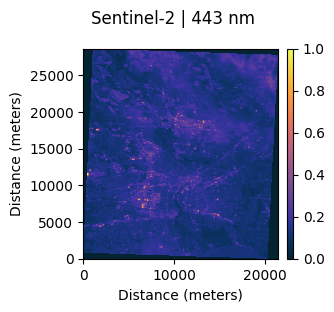

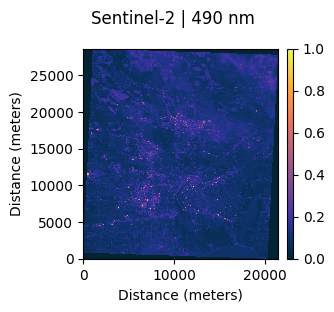

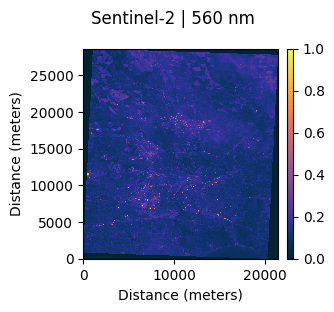

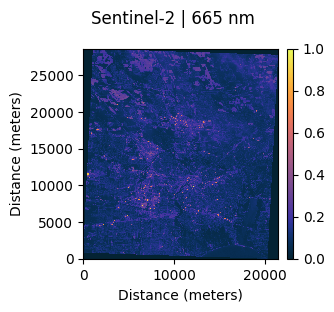

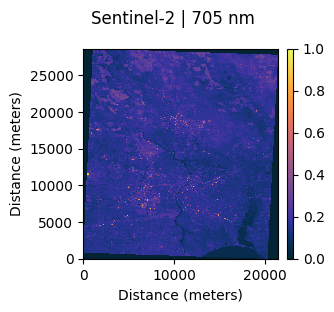

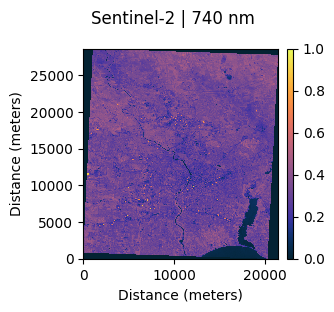

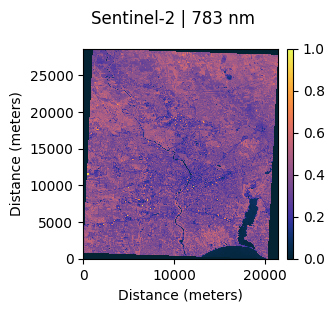

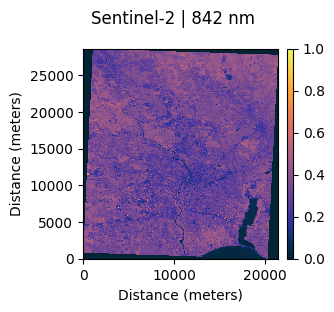

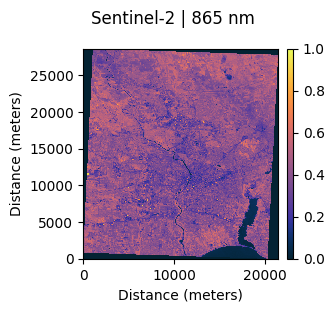

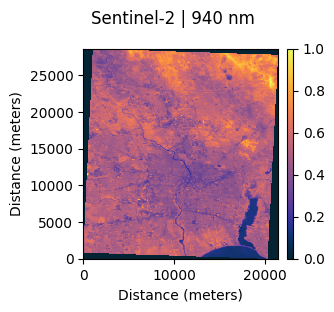

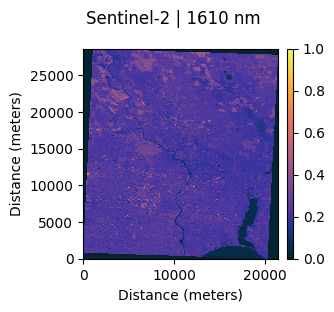

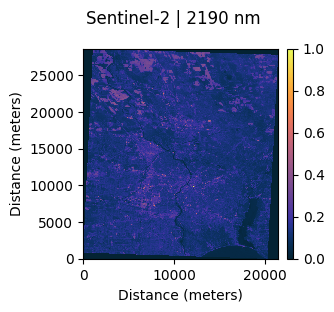

In [2]:
def plot_band(data, band, colormap_theme):
    """
    Plot a single Sentinel-2 band
    
    Args:
        data (numpy array): multispectral data input 
        band (numpy array): spectral band to be plotted (in range 1-12)
        colormap: colormap object or string
    Returns:
        plot object
    """
    # normalize the data for the band
    band_data = data[:, :, band]
    normalized_data = (band_data - np.nanmin(band_data)) / (np.nanmax(band_data) - np.nanmin(band_data))
    normalized_data[np.isnan(normalized_data)] = 0

    # list of wavelengths to be indexed alongside band for naming purposes
    wavelengths = ["443 nm", "490 nm", "560 nm", "665 nm", "705 nm", "740 nm", 
                   "783 nm", "842 nm", "865 nm", "940 nm", "1610 nm", "2190 nm"]

    # initialize subplots
    fig, ax = plt.subplots(figsize=(3, 3))
    fig.suptitle(f"Sentinel-2 | {wavelengths[band]}")

    # load cmap
    cmap = getattr(cmocean.cm, colormap_theme)

    # scale ticks by 30 m for corect distance display
    x = np.arange(normalized_data.shape[1]) * 30  # width in meters
    y = np.arange(normalized_data.shape[0]) * 30  # height in meters

    # one plot for one wavelength
    plot = ax.pcolormesh(x, y, normalized_data, cmap=cmap, shading="auto")
    
    # label axis
    ax.set_xlabel("Distance (meters)")
    ax.set_ylabel("Distance (meters)")
    fig.subplots_adjust(right=0.85, left=0.20, top=0.85, bottom=0.15)

    # add colorbar outside the figure
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(plot, cax=cbar_ax)

    plt.show()
    return plot

# iterate plot for each band in Sentinel-2 data
for i in range(12):
    plot = plot_band(wav_data, i, "thermal")
    plt.show(plot)

Statistical Definitions:
Mean: A type of average calculated by adding up all the numbers in a set and then dividing the sum by the total count of numbers in that set.
Standard Deviation (STD): A standard deviation is a measure of how dispersed the data is in relation to the mean. Low or small standard deviation indicates data are clustered tightly around the mean, and high or large standard deviation indicates data are more spread out.
Minimum: The single smallest value within a dataset.
Maximum: The single largest value within a dataset.
Quartiles: Divide the number of data points into four parts, or quarters, of more-or-less equal size. The data must be ordered from smallest to largest to compute quartiles. 
    - The first quartile (Q1) is defined as the 25th percentile, where the lowest 25% data lies below this point. 
    - The second quartile (Q2) is the median of a data set; thus 50% of the data lies below this point.
    - The third quartile (Q3) is the 75th percentile, where the lowest 75% data lies below this point. It is also known as the upper quartile.
Skewness: a measure of the asymmetry of a distribution about its mean.
Kurtosis: a measure of the combined weight of a distribution’s tails relative to the center of the distribution curve referred to as the mean.

The following table loops through each band calculate and display its statistics.

In [3]:
def calculate_band_statistics(data):
    """
    Calculate mean, std, minimum, maximum, quartiles, skewness, and kurtosis
    
    Args:
        data (numpy array): multispectral data input
    
    Returns:
        tabulated object
    
    """
    # create vectors to store statistical data for each band, perform calculation, store variable
    
    # create empty arrays for calculated data - errors indicate that values are being improperly indexed
    means = np.empty(12, dtype=float)
    stds = np.empty(12,dtype=float) 
    minimums = np.empty(12,dtype=float)
    maximums = np.empty(12,dtype=float)
    # the 25th, median, and 75th quatile will be stored in each column, wherein the row correspinds to each band. This will make indexing into the data easier later
    quantiles = np.empty((12, 3), dtype=float)
    skews = np.empty(12,dtype=float)
    kurts = np.empty(12,dtype=float)
    
    # iterate through each band and calculate stats
    for i in range(data.shape[2]):
        means[i] = np.mean(data[:,:,i])
        stds[i] = np.std(data[:,:,i]) 
        minimums[i] = np.min(data[:,:,i])
        maximums[i] = np.max(data[:,:,i])
        quantiles[i,:] = np.quantile(data[:,:,i].flatten(), [0.25, 0.5, 0.75]) # computes the 25th, median, and 75th quartile and stores them in the columns on an array.
        skews[i] = skew(data[:,:,i].flatten())
        kurts[i] = kurtosis(data[:,:,i].flatten())
        
    # format stats for display: convert arrays into lists
    stats = [
        ["mean"] + means.tolist(),
        ["std"] + stds.tolist(),
        ["min"] + minimums.tolist(),
        ["max"] + maximums.tolist(),
        ["Q1"] + quantiles[:, 0].tolist(), # index into appropriate column
        ["median"] + quantiles[:, 1].tolist(), # index into appropriate column
        ["Q3"] + quantiles[:, 2].tolist(), # index into appropriate column
        ["skew"] + skews.tolist(),
        ["kurtosis"] + kurts.tolist(),
    ]
    
    wavelengths = ["443nm", "490nm", "560nm", "665nm", "705nm", "740nm", "783nm", "842nm", "865nm", "940nm", "1610nm", "2190nm"]
    
    # tabulate is being used for its ease of use in data formatting, allowing for a descriptive header to be placed atop the stats. 
    print(tabulate(stats, headers=wavelengths))
    return stats

stats = calculate_band_statistics(wav_data)

              443nm       490nm       560nm       665nm      705nm       740nm      783nm      842nm      865nm      940nm      1610nm     2190nm
--------  ---------  ----------  ----------  ----------  ---------  ----------  ---------  ---------  ---------  ---------  ----------  ---------
mean      0.0817956   0.0853557   0.0973041   0.0869878  0.126105    0.224678    0.263642   0.268758   0.27994    0.318287   0.176831   0.11915
std       0.0358041   0.0417532   0.0434322   0.0495961  0.0536853   0.0876696   0.1066     0.109693   0.113284   0.118881   0.0692092  0.0580456
min       0           0           0           0          0           0           0          0          0          0          0          0
max       0.6021      0.7542      0.7484      0.7728     0.8159      0.783       0.7859     0.903      0.7689     0.6934     0.8196     0.9295
Q1        0.0676      0.0679      0.0822      0.0611     0.1105      0.2022      0.2293     0.2307     0.2433     0.2912     0.1649     0

Data standardization transforms data into a uniform format with a mean of 0 and standard deviation of 1. It ensures features with large ranges don’t dominate results and is key for consistent, reliable data analysis. This allows us to directly compare bands, detect extreme values (outliers), and understand anomalies in terms of how far they deviate from the “typical” values. For each reflectance value in each band, the z-score describes that value's position relative to the mean of a group of values. It is expressed in terms of standard deviations from the mean. The following code computes the z scores of the data, then uses the index of z scores greater than or equal to +/-3 to distinguish the outliers in the original raw values.

NAN values are accounted for via omission in the z score calculation (for outlier display), and by deliberate exclusion from the histogram (the function automatically does not plot them). This ensures the functions are not automatically plotting or representing the values in a matter unintentionally. 

In many of the plots, it seems that the number of outliers is relativley few, meaning most data falls close to the mean.

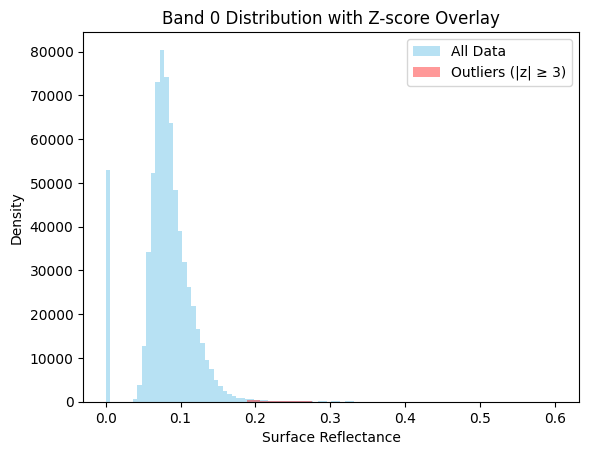

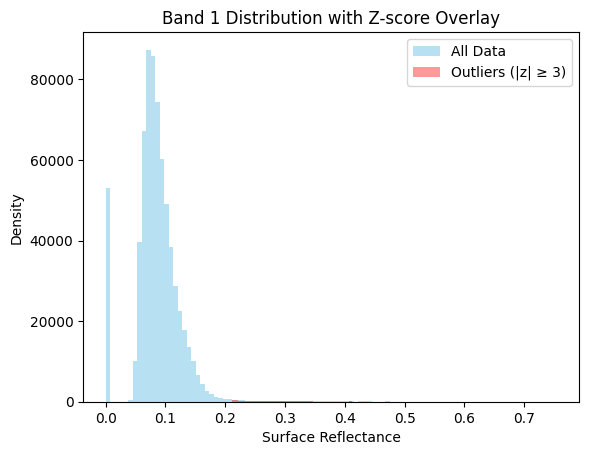

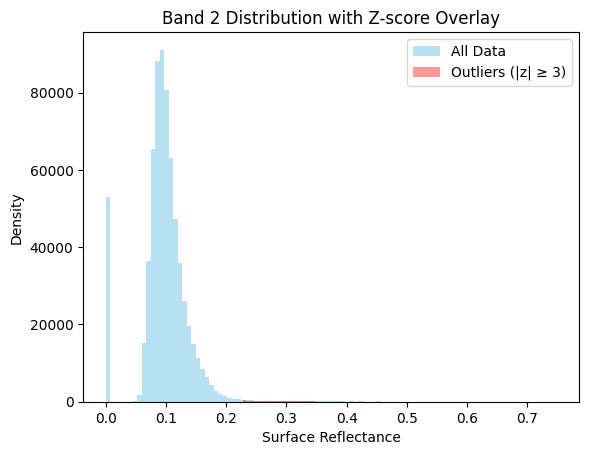

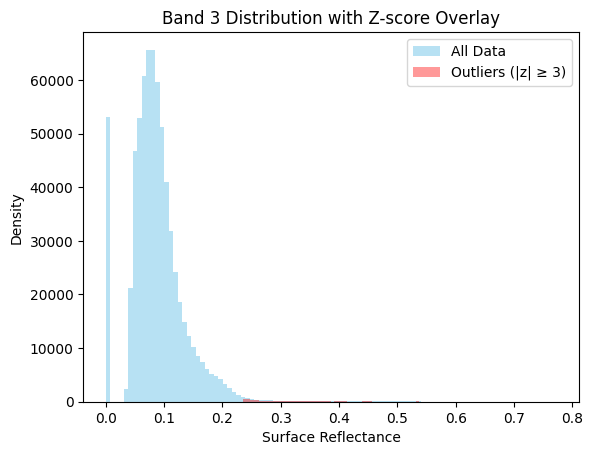

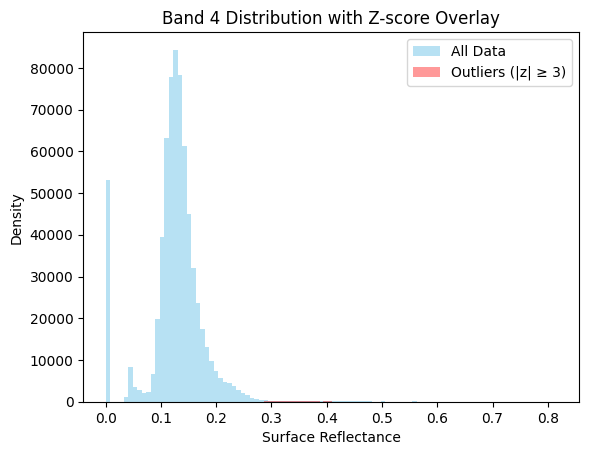

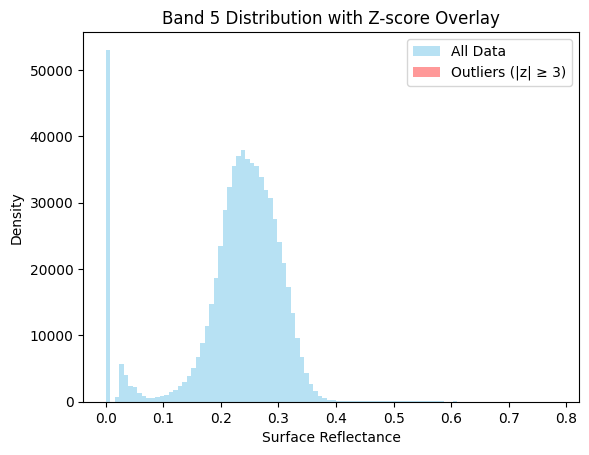

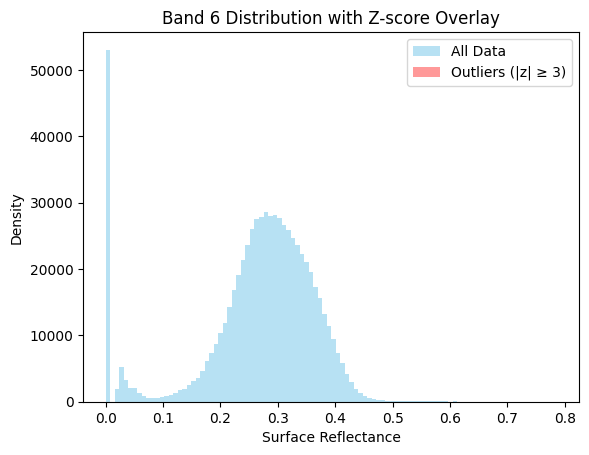

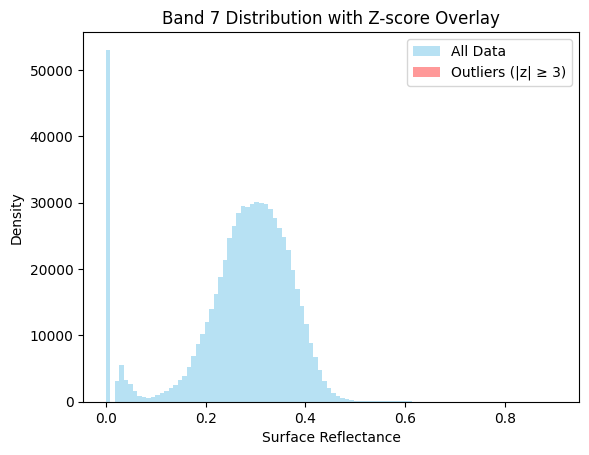

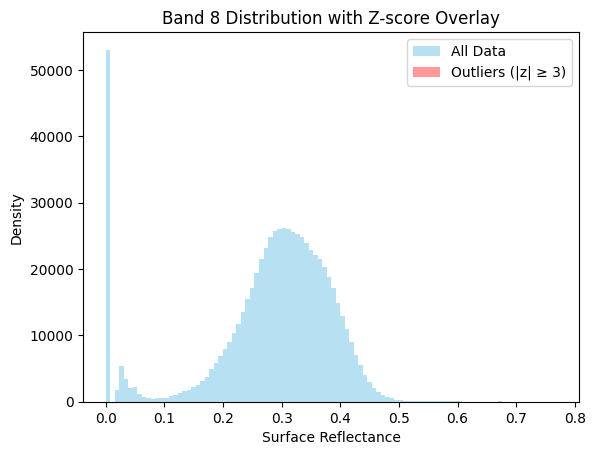

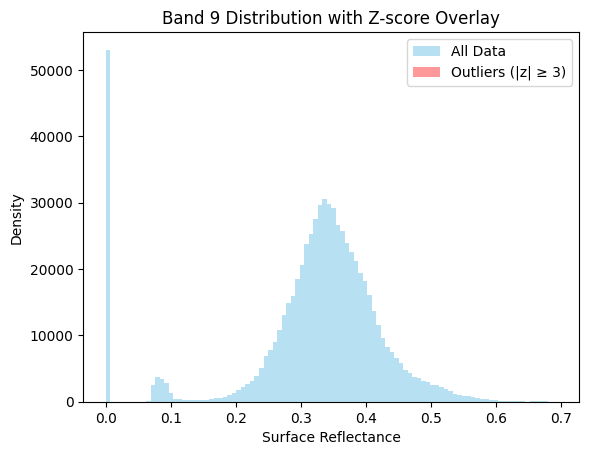

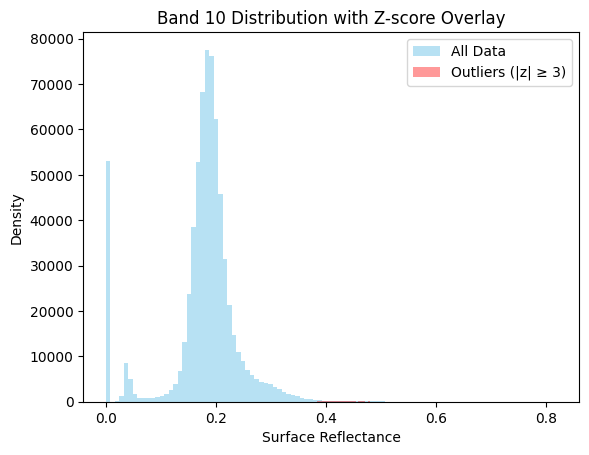

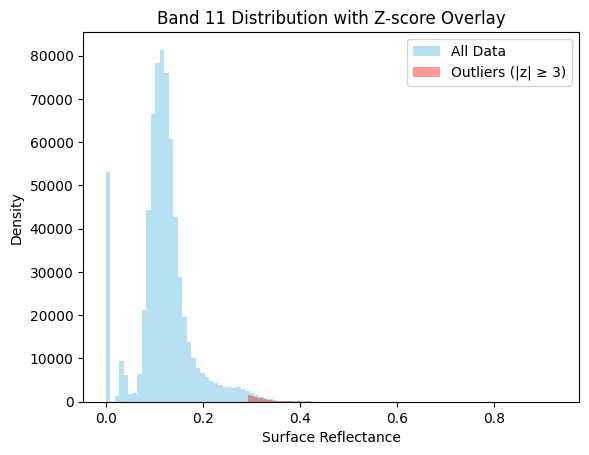

In [4]:
def standardize(data, band):
        """
         Calculate z scores for a single Sentinel 2 band

        Args:
                data (numpy array): multispectral data input 
                band (numpy array): spectral band to be plotted (in range 1-12)

        Returns:
                zscores: list of zscores for each input value
        """
        # calculate z scores from flattened data to ensure calculation occurs across 1 axis
        z_scores = zscore(data[:,:,band].flatten(), nan_policy='omit') # nan values are omitted
        return z_scores

#iterate across each band to plot
for i in range(12):
         # Standardize
        zscores = standardize(wav_data, i)
        band_data = wav_data[:,:,i].flatten()

        # determine index of zscore values +/-3, therby determining outliers
        tail_mask = (zscores >= 3) | (zscores <= -3)
        data_outliers = band_data[tail_mask]

        #intialize plots
        fig, ax = plt.subplots()

        # histogram of raw values, density = False so that data is no auto-scaled
        ax.hist(band_data[~np.isnan(band_data)], bins=100, density=False, 
                color='skyblue', alpha=0.6, label='All Data')
        # histogram of outlier values but in red, plotted overtop all values. This showcases outliers in the original data
        ax.hist(data_outliers, bins=100, density=False, 
                color='red', alpha=0.4, label='Outliers (|z| ≥ 3)')

        # Labels
        ax.set_xlabel('Surface Reflectance')
        ax.set_ylabel('Density')
        ax.set_title(f'Band {i} Distribution with Z-score Overlay')
        ax.legend()

        plt.show()


Pearson's r correlation coefficient is a statistical measure that quantifies the strength and direction of a linear relationship between two variables. Once computed, a correlation matrix is a square, symmetric, and positive semidefinite, characterized by having ones on the main diagonal (indicating perfect correlation of a variable with itself) and showing the pairwise correlation coefficients between different variables.

,443 nm,490 nm,560 nm,665 nm,705 nm,740 nm,783 nm,842 nm,865 nm,940 nm,1610 nm,2190 nm
443 nm,1.000000,0.910089,0.904518,0.859603,0.867354,0.519995,0.438285,0.428297,0.427099,0.566142,0.745102,0.776848
490 nm,0.910089,1.000000,0.984748,0.964237,0.921923,0.480250,0.386377,0.375325,0.373321,0.492937,0.759730,0.822917
560 nm,0.904518,0.984748,1.000000,0.960326,0.968272,0.595249,0.505361,0.496174,0.494045,0.583742,0.839738,0.860040
665 nm,0.859603,0.964237,0.960326,1.000000,0.929406,0.407676,0.307991,0.298391,0.299566,0.406843,0.786588,0.896290
705 nm,0.867354,0.921923,0.968272,0.929406,1.000000,0.698220,0.615618,0.608584,0.610949,0.671324,0.929635,0.906410
740 nm,0.519995,0.480250,0.595249,0.407676,0.698220,1.000000,0.990159,0.986438,0.987571,0.919488,0.797018,0.520721
783 nm,0.438285,0.386377,0.505361,0.307991,0.615618,0.990159,1.000000,0.994503,0.995988,0.909557,0.738871,0.439050
842 nm,0.428297,0.375325,0.496174,0.298391,0.608584,0.986438,0.994503,1.000000,0.994868,0.906273,0.736581,0.433464
865 nm,0.427099,0.373321,0.494045,0.299566,0.610949,0.987571,0.995988,0.994868,1.000000,0.912169,0.744488,0.439599
940 nm,0.566142,0.492937,0.583742,0.406843,0.671324,0.919488,0.909557,0.906273,0.912169,1.000000,0.755213,0.508542


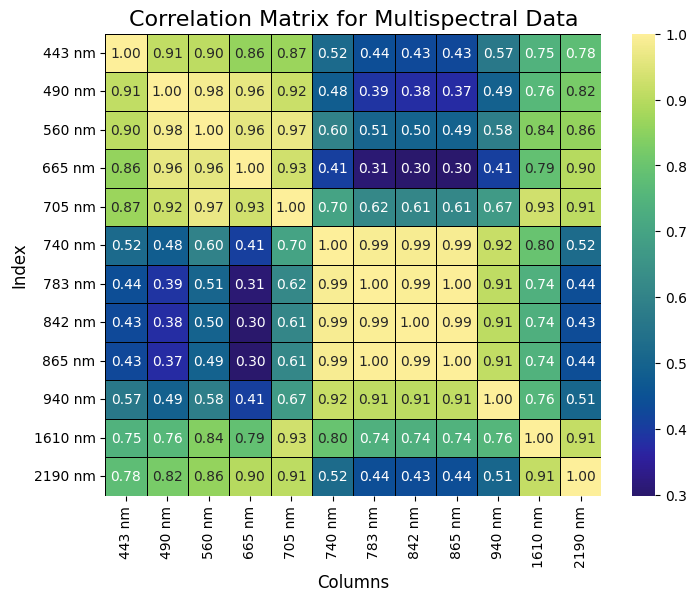

In [ ]:
def correlation_matrix(data, colormap_theme):
    """
    Args:
        data (numpy array): multispectral data input 
        colormap: colormap object or string
    Returns:
        plot object
    
    """
    # flatten the first two dimensions of the data, maintain 12 bands. This allows the values to be used to create a dataframe object and esier plotting later on.
    flattened = data.reshape(-1, data.shape[2])
    
    wavelengths = ["443 nm", "490 nm", "560 nm", "665 nm", "705 nm", "740 nm", 
                   "783 nm", "842 nm", "865 nm", "940 nm", "1610 nm", "2190 nm"]
        
    # create dataframe out of flattened data and wavelengths. This allows for easy acces by functions later on
    dataframe = pd.DataFrame(flattened, columns=wavelengths)

    # compute correlation matrix
    matrix = dataframe.corr()
    cmap = getattr(cmocean.cm, colormap_theme)
    
    #plot matrix
    plt.figure(figsize=(8, 6)) # Adjust figure size for better readability
    # create a heatmap for correlation values to show correlation through values, making the data more intuitive.
    sns.heatmap(matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=.5, linecolor='black')

    # 3. Add titles and labels
    plt.title('Correlation Matrix for Multispectral Data', fontsize=16)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Index', fontsize=12)

    return matrix

correlation_matrix(wav_data, 'haline')

A pairwise plot (or scatterplot matrix) shows all the relationships between numeric variables in a dataset. It creates a grid of plots where the diagonal displays the distribution of each individual variable, and the off-diagonal plots are scatterplots showing the relationship between each unique pair of variables. This is similar to a correlation matrix, however whereas a correlation matrix gives one value that quantifies the strength fo the realtionship between the two variables, a scatterplot hows the visual pattern between each of the two variables. A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions. This allows for soemone to see how closley values are clustered

In [ ]:
def correlation_plot(data):
    """
    Create two subplots for Sentinel-2 10m bands (B2, B3, B4, B8):
    1. Pairwise scatter plot matrix
    2. Density plot of point concentrations (2D KDE)
    
    Args:
        data (ndarray): 3D array of shape (n, m, b)
                       where b includes at least bands 2, 3, 4, 8
    """
    # Flatten spatial dimensions into rows
    flattened = data.reshape(-1, data.shape[2])

    # Select bands by index 
    band_indices = [1, 2, 3, 7]   # B2=490nm, B3=560nm, B4=665nm, B8=842nm
    wavelengths = ["B2 (490 nm)", "B3 (560 nm)", "B4 (665 nm)", "B8 (842 nm)"]

    # create dataframe for data accessability
    dataframe = pd.DataFrame(flattened[:, band_indices], columns=wavelengths)

    # 1. Pairwise scatterplot
    sns.pairplot(dataframe)
    plt.subplots_adjust(top=0.85)
    plt.suptitle("Pairwise Scatterplots (B2, B3, B4, B8)")

    # 2. Density 
    g = sns.pairplot(dataframe, kind = "kde")

    # Apply viridis colormap to all KDE plots
    for ax in g.axes.flatten():
        if ax is not None:
            for c in ax.collections:
                c.set_cmap("viridis")
                
    plt.subplots_adjust(top=0.85)
    plt.suptitle("Pairwise Desnity Scatterplots (B2, B3, B4, B8)")

correlation_plot(wav_data)

The following code loads in the ECOSTRESS datasets and resamples them by finding the smallest value after subtracting the desired wavelength from the sampled wavelength. This ensures that either the exact values are found (i.e samllest value will be 0), or that the next closest value will be idenitified in the event that the data does not sample the exact wavelength being looked for. Although more sophosticated ,ethods could be used to find the average between two values, for the purposes of this analysis and visualization, a simpler method seemed appopriate. 

In [ ]:
# load ECOSTRESS data
road_data = pd.read_csv("datasets/ecospeclib-1757914019205/manmade.road.pavingasphalt.solid.all.0674uuuasp.jhu.becknic.spectrum.txt", 
                   delim_whitespace=True,   
                   skiprows=21,             
                   header=None) 
oak_data = pd.read_csv("datasets/ecospeclib-1757914019205/vegetation.tree.quercus.agrifolia.vswir.jpl108.jpl.asd.spectrum.txt", 
                   delim_whitespace=True,   
                   skiprows=21,             
                   header=None) 
    
# initialize lists
resampled_oak = []
resampled_road = []

#list out the wavelengths that need to be found.
wavelengths = [0.490, 0.560, 0.665, 0.705, 0.740, 0.783, 0.842, 0.865, 0.1610, 0.2190]

# loop through each dataset for resampling 
for j in range(len(wavelengths)):    # Find index of closest wavelength in your data
    idx = np.argmin(np.abs(road_data.iloc[:, 0] - wavelengths[j]))
    # Grab the reflectance value
    resampled_road.append([road_data.iloc[idx, 0], road_data.iloc[idx, 1]])
        
for i in range(len(wavelengths)):    # Find index of closest wavelength in your data
    idx = np.argmin(np.abs(oak_data.iloc[:, 0] - wavelengths[i]))
    # Grab the reflectance value
    resampled_oak.append([oak_data.iloc[idx, 0], oak_data.iloc[idx, 1]])

# convert to DataFrame
resampled_road = pd.DataFrame(resampled_road, columns=["wavelength", "reflectance"])
resampled_oak = pd.DataFrame(resampled_oak, columns=["wavelength", "reflectance"])
# divide the reflectance data by 100 to keep the range between 0-1
ecostress_oak = np.array(resampled_oak) / 100.0
ecostress_road = np.array(resampled_road) / 100.0

/var/folders/sj/ndc3yh8s1yxc4npz15m9pyrh0000gn/T/ipykernel_31795/334735753.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  road_data = pd.read_csv("datasets/ecospeclib-1757914019205/manmade.road.pavingasphalt.solid.all.0674uuuasp.jhu.becknic.spectrum.txt",
/var/folders/sj/ndc3yh8s1yxc4npz15m9pyrh0000gn/T/ipykernel_31795/334735753.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  oak_data = pd.read_csv("datasets/ecospeclib-1757914019205/vegetation.tree.quercus.agrifolia.vswir.jpl108.jpl.asd.spectrum.txt",


/var/folders/sj/ndc3yh8s1yxc4npz15m9pyrh0000gn/T/ipykernel_31795/2126407140.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


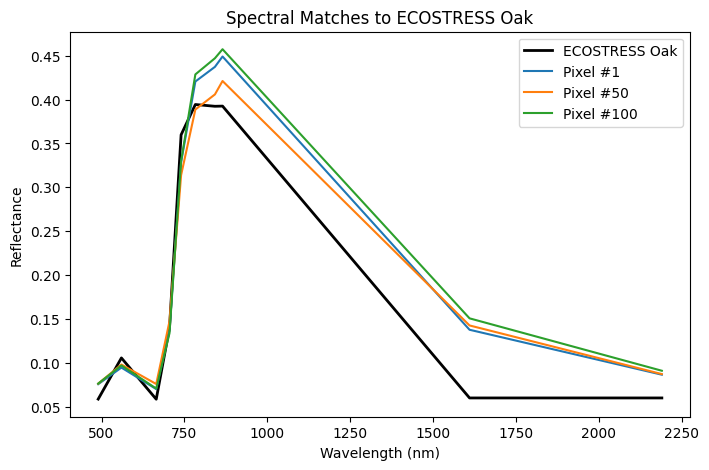

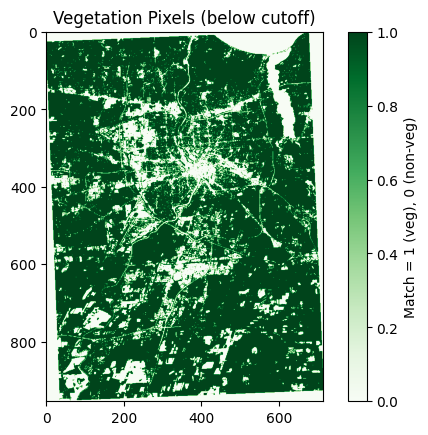

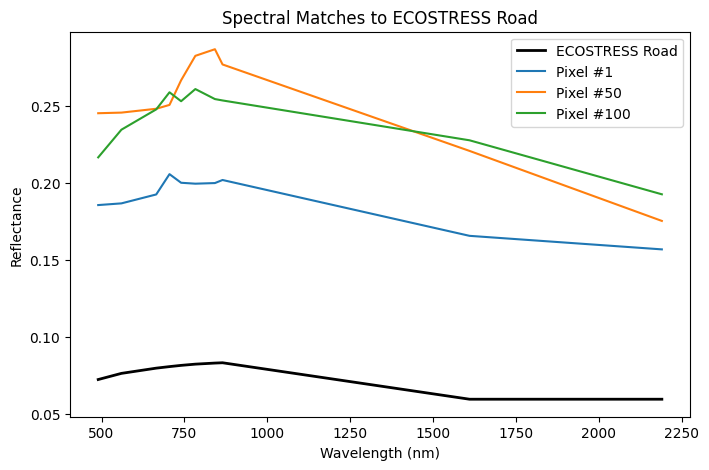

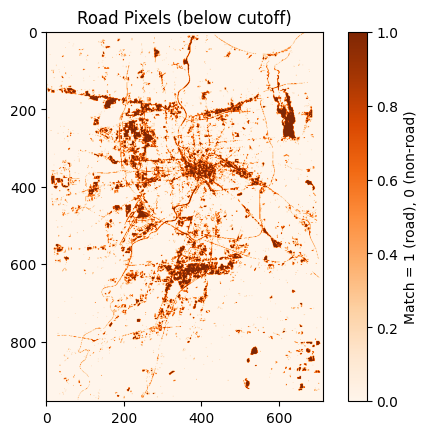

In [ ]:
# Define SAM
def sam(v1, v2):
    cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(cos_sim)   # spectral angle

# Sentinel-2 central wavelengths (nm), skipping 443 & 940 nm, and Band 10
s2_bands = np.array([
    490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190
])  

band_indices = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11]  
sentinel_pixels = wav_data.reshape(-1, wav_data.shape[2])[:, band_indices]

# Compute spectral angles vs ECOSTRESS
oak_angles = np.array([sam(px, ecostress_oak[:,1]) for px in sentinel_pixels])
road_angles = np.array([sam(px, ecostress_road[:,1]) for px in sentinel_pixels])

# Find 100 closest matches for oak 
oak_closest_idx = np.argsort(oak_angles)[:100]

# plot oak plot
plt.figure(figsize=(8, 5))
plt.plot(s2_bands, ecostress_oak[:,1], label="ECOSTRESS Oak", linewidth=2, color="black")
plt.plot(s2_bands, sentinel_pixels[oak_closest_idx[0]], label="Pixel #1")
plt.plot(s2_bands, sentinel_pixels[oak_closest_idx[49]], label="Pixel #50")
plt.plot(s2_bands, sentinel_pixels[oak_closest_idx[99]], label="Pixel #100")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.title("Spectral Matches to ECOSTRESS Oak")
plt.show()

# Vegetation mask
veg_mask = oak_angles.reshape(wav_data.shape[0], wav_data.shape[1]) < 0.43

plt.imshow(veg_mask, cmap="Greens")
plt.title("Vegetation Pixels (below cutoff)")
plt.colorbar(label="Match = 1 (veg), 0 (non-veg)")
plt.show()

# Find 100 closest matches for road
road_closest_idx = np.argsort(road_angles)[:100]

#plot road plot 
plt.figure(figsize=(8, 5))
plt.plot(s2_bands, ecostress_road[:,1], label="ECOSTRESS Road", linewidth=2, color="black")
plt.plot(s2_bands, sentinel_pixels[road_closest_idx[0]], label="Pixel #1")
plt.plot(s2_bands, sentinel_pixels[road_closest_idx[49]], label="Pixel #50")
plt.plot(s2_bands, sentinel_pixels[road_closest_idx[99]], label="Pixel #100")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.title("Spectral Matches to ECOSTRESS Road")
plt.show()

#  Road mask
road_mask = road_angles.reshape(wav_data.shape[0], wav_data.shape[1]) < 0.23

plt.imshow(road_mask, cmap="Oranges")
plt.title("Road Pixels (below cutoff)")
plt.colorbar(label="Match = 1 (road), 0 (non-road)")
plt.show()

The "Spectral Matches to ECOSTRESS Oak" and "Spectral Matches to ECOSTRESS road" display the cos similarily value determined for each pixel of the Sentinel 2 satellite data compared against the singular ECOSTRESS data pixels for oak and road refelctance. Each pixel being compared is a vector of wavelength values representing reflectance at that one spatial point. For the oak data, the Sentinel 2 1st through 100 closest matches display a close relationship to the ECOSTRESS data until 750nm, at which point the closest values begin to show greater reflectance for their wavelengths. The road data displays a differnce relatiosnhip, with the first 100 values not displaying a close similarity with the ECOSTRESS road data at all, having about 0.10% greater reflectance for the closest values. FOr both datasets, despite the fact the the reflectance values are greater at different points, they still follow roughly the same curvature. I was able to use both of these charts to determine a threshold value for the vegatation and road masks. For the oak mask, I chose a value of 0.43, since the sentinel data underneath this reflectance displays a fairly close relationship for the 1st theough 100th pixels, and encompasses the peak reflectance for the original data and the closest peak of sentinel data. I omnly wanted to include the peaks of these two sets within my mask so as to ensure I was not including noise of non-veg areas in my final plot. My reaoning was sinal for the road mask. I set the mask value at 0.23 to encompass roughly the lowest 50ih values of sentinel 2 dataset matches. I foudn that when playing around with the mask value, this maintained better representation of the roadways, with lower values not always including the roads, and higher values introducing reflectance on non road objects. 

SyntaxError: invalid syntax (2417659736.py, line 1)